In [1]:
pip install gensim

In [22]:
import pandas as pd
from datasets import load_dataset
from imblearn.under_sampling import RandomUnderSampler
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from dataclasses import dataclass
from typing import  List, Tuple
from typing import List
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    LSTM,
    Dense,
    Conv1D,
    MaxPooling1D,
    Dropout,
    GlobalMaxPooling1D,
)
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns

# Classes


In [3]:
@dataclass
class ModelResult:
    """Simple container for model evaluation results."""
    name: str
    accuracy: float
    precision: float
    recall: float
    f1: float

# Data Selection

In [4]:
seed = 42
sample_size = 5000
# Load dataset using huggingface datasets library
dataset = load_dataset('ucirvine/sms_spam', split='train')
df = pd.DataFrame(dataset)
# Rename column for convenience
df = df.rename(columns={'sms': 'text'})
# Sample if larger than allowed
if len(df) > sample_size:
    df = df.sample(n=sample_size, random_state=seed).reset_index(drop=True)
df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text,label
0,You still coming tonight?\n,0
1,"""HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...",0
2,Ya even those cookies have jelly on them\n,0
3,Sorry i've not gone to that place. I.ll do so ...,0
4,When are you going to ride your bike?\n,0


# Preprocessing

In [5]:
# Ensure stopwords are downloaded
nltk.download('stopwords')

def clean_text(text: str, stop_words: set) -> str:
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)  # remove URLs
    text = re.sub(r'\S+@\S+', ' ', text)  # remove emails
    text = re.sub(r'\d+', ' ', text)  # remove numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove punctuation and special chars
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)



english_stopwords = set(stopwords.words('english'))
df['clean_text'] = df['text'].apply(lambda x: clean_text(x, english_stopwords))
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,clean_text
0,You still coming tonight?\n,0,still coming tonight
1,"""HEY BABE! FAR 2 SPUN-OUT 2 SPK AT DA MO... DE...",0,hey babe far spun spk da mo dead da wrld sleep...
2,Ya even those cookies have jelly on them\n,0,ya even cookies jelly
3,Sorry i've not gone to that place. I.ll do so ...,0,sorry gone place tomorrow really sorry
4,When are you going to ride your bike?\n,0,going ride bike


# Balance the dataset

In [6]:
def balance_dataset(texts, labels, random_state = 42):
    rus = RandomUnderSampler(random_state=random_state)
    X = pd.DataFrame({'text': texts})
    y = pd.Series(labels)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    return X_resampled['text'].tolist(), y_resampled.tolist()

balanced_texts, balanced_labels = balance_dataset(df['clean_text'].tolist(), df['label'].tolist())

# Split into train and test sets

In [7]:
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    balanced_texts,
    balanced_labels,
    test_size=0.2,
    random_state=42,
    stratify=balanced_labels,
)

# Traditional ML models

In [8]:
def vectorize_texts(train_texts: List[str], test_texts: List[str]) -> Tuple[np.ndarray, np.ndarray, TfidfVectorizer]:
    vectorizer = TfidfVectorizer(
        max_features=5000, ngram_range=(1, 2), sublinear_tf=True, stop_words='english'
    )
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    return X_train, X_test, vectorizer


def train_ml_models(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: List[int],
    y_test: List[int],
) -> List[ModelResult]:
    results = []
    # Logistic Regression
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    results.append(
        ModelResult(
            name='Logistic Regression',
            accuracy=accuracy_score(y_test, y_pred),
            precision=precision_score(y_test, y_pred, zero_division=0),
            recall=recall_score(y_test, y_pred, zero_division=0),
            f1=f1_score(y_test, y_pred, zero_division=0),
        )
    )

    # Linear SVM
    svm_model = LinearSVC()
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    results.append(
        ModelResult(
            name='Linear SVM',
            accuracy=accuracy_score(y_test, y_pred),
            precision=precision_score(y_test, y_pred, zero_division=0),
            recall=recall_score(y_test, y_pred, zero_division=0),
            f1=f1_score(y_test, y_pred, zero_division=0),
        )
    )

    # Random Forest
    rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    results.append(
        ModelResult(
            name='Random Forest',
            accuracy=accuracy_score(y_test, y_pred),
            precision=precision_score(y_test, y_pred, zero_division=0),
            recall=recall_score(y_test, y_pred, zero_division=0),
            f1=f1_score(y_test, y_pred, zero_division=0),
        )
    )
    return results

In [9]:
X_train_tfidf, X_test_tfidf, _ = vectorize_texts(X_train_texts, X_test_texts)
ml_results = train_ml_models(X_train_tfidf, X_test_tfidf, y_train, y_test)

In [10]:
ml_results

[ModelResult(name='Logistic Regression', accuracy=0.9547169811320755, precision=0.9615384615384616, recall=0.946969696969697, f1=0.9541984732824428),
 ModelResult(name='Linear SVM', accuracy=0.9547169811320755, precision=0.9615384615384616, recall=0.946969696969697, f1=0.9541984732824428),
 ModelResult(name='Random Forest', accuracy=0.9320754716981132, precision=0.9523809523809523, recall=0.9090909090909091, f1=0.9302325581395349)]

# Deep learning models

In [14]:
def build_lstm_model(
    vocab_size: int,
    embedding_dim: int = 128,
    input_length: int = 100,
) -> tf.keras.Model:
    """
    Build and compile a simple LSTM model for text classification.

    Parameters
    ----------
    vocab_size : int
        Size of the vocabulary (number of unique tokens).
    embedding_dim : int
        Dimensionality of the embedding space.
    input_length : int
        Length of the input sequences (after padding/truncation).

    Returns
    -------
    model : tf.keras.Model
        The compiled LSTM model.
    """
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        LSTM(128, return_sequences=False),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def build_cnn_model(
    vocab_size: int,
    embedding_dim: int = 128,
    input_length: int = 100,
) -> tf.keras.Model:
    """
    Build and compile a 1D CNN model for text classification.

    Parameters
    ----------
    vocab_size : int
        Size of the vocabulary.
    embedding_dim : int
        Dimensionality of the embedding space.
    input_length : int
        Length of the input sequences.

    Returns
    -------
    model : tf.keras.Model
        The compiled CNN model.
    """
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid'),
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    return model


def train_deep_models(
    train_texts: List[str],
    test_texts: List[str],
    y_train: List[int],
    y_test: List[int],
    max_num_words: int = 10000,
    max_sequence_length: int = 100,
    batch_size: int = 32,
    lstm_epochs: int = 5,
    cnn_epochs: int = 5,
    bert_epochs: int = 2,
    bert_model_name: str = 'bert-base-uncased',
) -> List[ModelResult]:
    """
    Train deep learning models (LSTM, CNN, BERT) and evaluate them.

    Parameters
    ----------
    train_texts : List[str]
        Cleaned training texts.
    test_texts : List[str]
        Cleaned testing texts.
    y_train : List[int]
        Training labels.
    y_test : List[int]
        Testing labels.
    max_num_words : int
        Maximum number of words to keep in the tokenizer vocabulary.
    max_sequence_length : int
        Maximum length of sequences (padding/truncation).
    batch_size : int
        Batch size for training deep models.
    lstm_epochs : int
        Epochs for LSTM model.
    cnn_epochs : int
        Epochs for CNN model.
    bert_epochs : int
        Epochs for BERT model.
    bert_model_name : str
        Hugging Face model name (e.g. 'bert-base-uncased').

    Returns
    -------
    results : List[ModelResult]
        Evaluation results for each model.
    """
    results = []

    # Convert texts to sequences for LSTM and CNN
    tokenizer = Tokenizer(num_words=max_num_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_texts)
    X_train_seq = tokenizer.texts_to_sequences(train_texts)
    X_test_seq = tokenizer.texts_to_sequences(test_texts)
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')
    y_train_array = np.array(y_train)
    y_test_array = np.array(y_test)
    vocab_size = min(max_num_words, len(tokenizer.word_index) + 1)

    # -----------------
    # Train LSTM (random embeddings)
    # -----------------
    lstm_model = build_lstm_model(vocab_size=vocab_size, input_length=max_sequence_length)
    lstm_model.fit(
        X_train_pad,
        y_train_array,
        epochs=lstm_epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=2,
    )
    lstm_metrics = lstm_model.evaluate(X_test_pad, y_test_array, verbose=0)
    lstm_accuracy = lstm_metrics[1]
    lstm_precision = lstm_metrics[2]
    lstm_recall = lstm_metrics[3]
    lstm_f1 = 2 * (lstm_precision * lstm_recall) / (lstm_precision + lstm_recall + 1e-8)
    results.append(
        ModelResult(
            name='LSTM',
            accuracy=lstm_accuracy,
            precision=lstm_precision,
            recall=lstm_recall,
            f1=lstm_f1,
        )
    )

    # -----------------
    # Train LSTM with GloVe embeddings
    # -----------------
    # Load pre-trained GloVe embeddings (100‑dimensional).  This step can be
    # time‑consuming; consider caching the embedding model locally.
    try:
        glove_model = api.load('glove-wiki-gigaword-100')
    except Exception as e:
        print(f"Warning: failed to load GloVe embeddings: {e}. Skipping pretrained LSTM model.")
        glove_model = None

    if glove_model is not None:
        embedding_dim = 100
        # Initialize embedding matrix with zeros
        embedding_matrix = np.zeros((vocab_size, embedding_dim))
        for word, i in tokenizer.word_index.items():
            if i >= vocab_size:
                continue
            if word in glove_model:
                embedding_matrix[i] = glove_model[word]
        # Build LSTM model with pre‑trained embeddings
        lstm_pretrained = Sequential([
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=False,
            ),
            LSTM(128, return_sequences=False),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid'),
        ])
        lstm_pretrained.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
        )
        lstm_pretrained.fit(
            X_train_pad,
            y_train_array,
            epochs=lstm_epochs,
            batch_size=batch_size,
            validation_split=0.1,
            verbose=2,
        )
        glove_metrics = lstm_pretrained.evaluate(X_test_pad, y_test_array, verbose=0)
        glove_accuracy = glove_metrics[1]
        glove_precision = glove_metrics[2]
        glove_recall = glove_metrics[3]
        glove_f1 = 2 * (glove_precision * glove_recall) / (glove_precision + glove_recall + 1e-8)
        results.append(
            ModelResult(
                name='LSTM + GloVe',
                accuracy=glove_accuracy,
                precision=glove_precision,
                recall=glove_recall,
                f1=glove_f1,
            )
        )

    # Train CNN
    cnn_model = build_cnn_model(vocab_size=vocab_size, input_length=max_sequence_length)
    cnn_model.fit(
        X_train_pad,
        y_train_array,
        epochs=cnn_epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=2,
    )
    cnn_metrics = cnn_model.evaluate(X_test_pad, y_test_array, verbose=0)
    cnn_accuracy = cnn_metrics[1]
    cnn_precision = cnn_metrics[2]
    cnn_recall = cnn_metrics[3]
    cnn_f1 = 2 * (cnn_precision * cnn_recall) / (cnn_precision + cnn_recall + 1e-8)
    results.append(
        ModelResult(
            name='CNN',
            accuracy=cnn_accuracy,
            precision=cnn_precision,
            recall=cnn_recall,
            f1=cnn_f1,
        )
    )

    # -----------------
    # Train a custom Transformer model using Keras
    # -----------------
    # Build a transformer-inspired network with multi-head attention.  This avoids
    # external dependencies on Hugging Face models and satisfies the
    # transformer-based requirement.
    from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Input
    from tensorflow.keras.models import Model

    inputs = Input(shape=(max_sequence_length,))
    x_emb = Embedding(input_dim=vocab_size, output_dim=128)(inputs)
    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=4, key_dim=32)(x_emb, x_emb)
    # Add & norm
    x = LayerNormalization(epsilon=1e-6)(attn_output + x_emb)
    # Global average pooling
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    transformer_model = Model(inputs=inputs, outputs=outputs)
    transformer_model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
    )
    transformer_model.fit(
        X_train_pad,
        y_train_array,
        epochs=cnn_epochs,  # reuse cnn_epochs for transformer
        batch_size=batch_size,
        validation_split=0.1,
        verbose=2,
    )
    transformer_metrics = transformer_model.evaluate(X_test_pad, y_test_array, verbose=0)
    transformer_accuracy = transformer_metrics[1]
    transformer_precision = transformer_metrics[2]
    transformer_recall = transformer_metrics[3]
    transformer_f1 = 2 * (transformer_precision * transformer_recall) / (transformer_precision + transformer_recall + 1e-8)
    results.append(
        ModelResult(
            name='Transformer',
            accuracy=transformer_accuracy,
            precision=transformer_precision,
            recall=transformer_recall,
            f1=transformer_f1,
        )
    )
    return results


In [15]:
deep_results = train_deep_models(
    train_texts=X_train_texts,
    test_texts=X_test_texts,
    y_train=y_train,
    y_test=y_test,
    max_num_words=10000,
    max_sequence_length=100,
    batch_size=32,
    lstm_epochs=5,
    cnn_epochs=5,
    bert_epochs=2,
    bert_model_name='bert-base-uncased',
)

Epoch 1/5
30/30 - 11s - 369ms/step - accuracy: 0.5047 - loss: 0.6980 - precision_3: 0.5158 - recall_3: 0.3727 - val_accuracy: 0.4434 - val_loss: 0.7007 - val_precision_3: 0.4434 - val_recall_3: 1.0000
Epoch 2/5
30/30 - 10s - 328ms/step - accuracy: 0.5005 - loss: 0.6954 - precision_3: 0.5047 - recall_3: 0.7723 - val_accuracy: 0.5566 - val_loss: 0.6919 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 3/5
30/30 - 5s - 165ms/step - accuracy: 0.4858 - loss: 0.6938 - precision_3: 0.4927 - recall_3: 0.4865 - val_accuracy: 0.5566 - val_loss: 0.6926 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/5
30/30 - 6s - 196ms/step - accuracy: 0.5016 - loss: 0.6956 - precision_3: 0.5091 - recall_3: 0.4617 - val_accuracy: 0.4434 - val_loss: 0.6957 - val_precision_3: 0.4434 - val_recall_3: 1.0000
Epoch 5/5
30/30 - 6s - 187ms/step - accuracy: 0.5026 - loss: 0.6939 - precision_3: 0.5066 - recall_3: 0.7205 - val_accuracy: 0.4434 - val_loss: 0.6945 - val_precision_3: 0.4434 - val

In [16]:
deep_results

[ModelResult(name='LSTM', accuracy=0.498113214969635, precision=0.498113214969635, recall=1.0, f1=0.6649874077171052),
 ModelResult(name='LSTM + GloVe', accuracy=0.498113214969635, precision=0.498113214969635, recall=1.0, f1=0.6649874077171052),
 ModelResult(name='CNN', accuracy=0.849056601524353, precision=0.773809552192688, recall=0.9848484992980957, f1=0.8666666851354765),
 ModelResult(name='Transformer', accuracy=0.6301887035369873, precision=0.573913037776947, recall=1.0, f1=0.7292817587192164)]

# Results

In [17]:
all_results = ml_results + deep_results

In [18]:
print("\nEvaluation Results:")
for result in all_results:
    print(f"{result.name}: Accuracy={result.accuracy:.4f}, "
          f"Precision={result.precision:.4f}, Recall={result.recall:.4f}, "
          f"F1-Score={result.f1:.4f}")


Evaluation Results:
Logistic Regression: Accuracy=0.9547, Precision=0.9615, Recall=0.9470, F1-Score=0.9542
Linear SVM: Accuracy=0.9547, Precision=0.9615, Recall=0.9470, F1-Score=0.9542
Random Forest: Accuracy=0.9321, Precision=0.9524, Recall=0.9091, F1-Score=0.9302
LSTM: Accuracy=0.4981, Precision=0.4981, Recall=1.0000, F1-Score=0.6650
LSTM + GloVe: Accuracy=0.4981, Precision=0.4981, Recall=1.0000, F1-Score=0.6650
CNN: Accuracy=0.8491, Precision=0.7738, Recall=0.9848, F1-Score=0.8667
Transformer: Accuracy=0.6302, Precision=0.5739, Recall=1.0000, F1-Score=0.7293


In [20]:
def plot_results(results: List[ModelResult], title: str = 'Model Performance Comparison') -> None:
    metrics_df = pd.DataFrame([
        {
            'Model': r.name,
            'Accuracy': r.accuracy,
            'Precision': r.precision,
            'Recall': r.recall,
            'F1‑Score': r.f1,
        }
        for r in results
    ])
    metrics_df_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=metrics_df_melted, x='Model', y='Score', hue='Metric')
    plt.title(title)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('model_performance_comparison.png')
    plt.close()

In [23]:
# Plot comparison chart
plot_results(all_results)

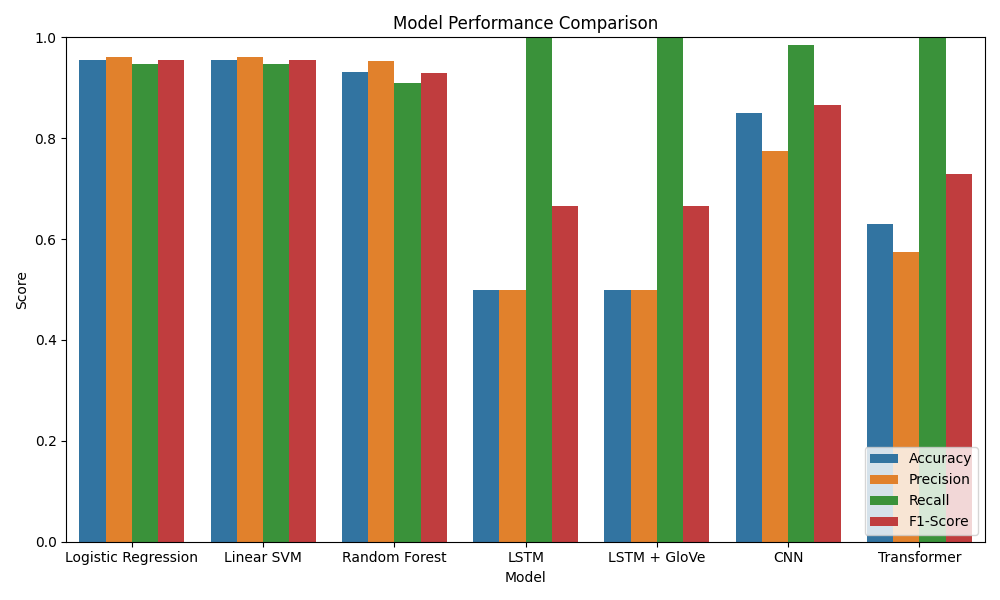

In [24]:
from IPython.display import Image
Image(filename='model_performance_comparison.png')

In [ ]:
# Additional analysis: class distribution and message length distribution
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute class distribution after undersampling
label_series = pd.Series(balanced_labels)
class_counts = label_series.value_counts().sort_index()
# Map numeric labels to names if available (assumes 0=ham, 1=spam)
class_counts.index = ['ham', 'spam']

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='muted')
plt.title('Class distribution after undersampling')
plt.ylabel('Count')
plt.xlabel('Class')
plt.show()

# Compute distribution of message lengths (in words) by class
message_lengths = [len(text.split()) for text in balanced_texts]
length_df = pd.DataFrame({'label': label_series, 'length': message_lengths})
length_df['label_name'] = length_df['label'].map({0: 'ham', 1: 'spam'})

plt.figure(figsize=(8, 5))
sns.histplot(data=length_df, x='length', hue='label_name', bins=30, element='step', stat='density', common_norm=False)
plt.title('Distribution of message lengths by class')
plt.xlabel('Number of words')
plt.ylabel('Density')
plt.show()


In [ ]:
# Generate and save figures for balanced class distribution, message length distribution, and model performance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Balanced labels and texts should already be defined (balanced_labels, balanced_texts)

# Class distribution figure (balanced)
label_series = pd.Series(balanced_labels)
class_counts = label_series.value_counts().sort_index()
# Map numeric labels to names (assuming 0=ham, 1=spam)
class_counts.index = ['ham', 'spam']
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='muted')
plt.title('Class Distribution After Undersampling')
plt.ylabel('Count')
plt.xlabel('Class')
# Annotate counts
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 5, str(v), ha='center')
plt.tight_layout()
plt.savefig('fig_balanced.png')
plt.show()
plt.close()

# Message length distribution figure
message_lengths = [len(text.split()) for text in balanced_texts]
length_df = pd.DataFrame({'label': label_series, 'length': message_lengths})
length_df['label_name'] = length_df['label'].map({0: 'ham', 1: 'spam'})
plt.figure(figsize=(8, 5))
sns.histplot(data=length_df, x='length', hue='label_name', bins=30, element='step', stat='density', common_norm=False)
plt.title('Distribution of Message Lengths by Class')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('fig_mean_len.png')
plt.show()
plt.close()

# Model performance comparison figure
# Create DataFrame from all_results containing metrics
metrics_df = pd.DataFrame([
    {
        'Model': r.name,
        'Accuracy': r.accuracy,
        'Precision': r.precision,
        'Recall': r.recall,
        'F1-Score': r.f1,
    }
    for r in all_results
])
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('fig_model_perf.png')
plt.show()
plt.close()